# Model improvement by (random) forests
### We can instead of one Machine Learning model train several and compare their predictions. Perhaps the most obvious way to do this is to build a number of independent models. We can create "multiple" data sets, with a technique in statistics called the bootstrap. In this technique, we resample from our data set to produce a new set, and then another new set, and so on.


* We can improve the performance of a Machine Learning system if, instead of one model, we use many.

* The basic idea is the *wisdom of crowds*.

* Often, the opinion of many people is better than the opinion of an expert.

* We train a Machine Learning model on each of the datasets we have constructed.

* Let's see this in action, using data from California home prices.

In [1]:
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing(as_frame=True)
cal_housing.data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


* Our goal is to predict the price of the house, which is given to us in hundreds of thousands of dollars.

In [2]:
cal_housing.target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

* To get an idea of ​​our predictions, let's look at our target's key metrics:

In [3]:
cal_housing.target.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

* We'll start with a `DecisionTreeRegressor`.

* We will measure the error based on the Mean Absolute Error.

* In scikit-learn, as a metric it appears as `neg_mean_absolute_error` (because we usually want to minimize it), so we will change its sign.

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cal_tree = DecisionTreeRegressor()
cv_scores = cross_val_score(cal_tree,
                            cal_housing.data, 
                            cal_housing.target, 
                            cv=KFold(n_splits=5, shuffle=True),
                            scoring="neg_mean_absolute_error",
                            n_jobs=-1)
print(-cv_scores.mean(), cv_scores.std())

0.46377537839147287 0.011082663360586144


* The ``crowd'' implementation in scikit-learn is via `BaggingRegressor` and `BaggingClassifier`.

In [5]:
from sklearn.ensemble import BaggingRegressor

bagging_cal_tree = BaggingRegressor(DecisionTreeRegressor(),
                                    n_estimators=50, 
                                    n_jobs=-1)
bagged_cv_scores = cross_val_score(bagging_cal_tree, 
                                   cal_housing.data,
                                   cal_housing.target,
                                   cv=KFold(n_splits=5, shuffle=True),
                                   scoring="neg_mean_absolute_error",
                                   n_jobs=-1)

print(-bagged_cv_scores.mean(), bagged_cv_scores.std())

0.3296109187693798 0.005475924107773882


* A more advanced approach is *random forests*.

* As before, we build a series of independent models, namely, decision trees.

* However, at each node we do not investigate all $p$ characteristics of the data for the question we will ask, but a random subset of them, such as $\sqrt{p}$.

* The idea is that we want our crowd to be diverse. So this way we ensure that not all trees will be similar (since for example they won't all have the same question at the root).

* Random forests are implemented via `RamdomForestRegressor` and `RandomForestClassifier`.

In [6]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=50, n_jobs=-1)
forest_cv_scores = cross_val_score(forest,  
                                   cal_housing.data,
                                   cal_housing.target,
                                   cv=KFold(n_splits=5, shuffle=True),
                                   scoring="neg_mean_absolute_error",
                                   n_jobs=-1)
print(-forest_cv_scores.mean(), forest_cv_scores.std())

0.3294641792926356 0.00790640108650972


* We can take thoughtfulness one step further.

* In *extremely randomised trees*, we stochastically choose not only the attribute to query each node, but also the value of the query.

* Extreme stochastic trees are implemented via `ExtraTreesRegressor` and `ExtraTreesClassifier`.

In [7]:
from sklearn.ensemble import ExtraTreesRegressor

extremely_rts = ExtraTreesRegressor(n_estimators=50, n_jobs=-1)

extremely_cv_scores = cross_val_score(extremely_rts, 
                                      cal_housing.data,
                                      cal_housing.target,
                                      cv=KFold(n_splits=5, shuffle=True),
                                      scoring="neg_mean_absolute_error",
                                      n_jobs=-1)
print(-extremely_cv_scores.mean(), extremely_cv_scores.std())

0.33051568577519375 0.004086633728157167


* Typically, these approaches yield better results than individual models.

* But while decision trees have, as we have said, very good interpretability, when we have many trees or forests the situation changes somewhat.

* If we want to see how our complex models make their decisions, we can extract the *feature importances*, which give us an overall indication of how important each feature is to the model's predictions.

In [8]:
import numpy as np

extremely_rts = ExtraTreesRegressor(n_estimators=50, n_jobs=-1)
extremely_rts.fit(cal_housing.data, cal_housing.target)
importances = extremely_rts.feature_importances_

std = np.std([tree.feature_importances_ for tree in extremely_rts.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

for i in indices:
    print(cal_housing.feature_names[i], importances[i])

MedInc 0.5036509949503956
Longitude 0.10925484116381018
AveOccup 0.10810250136464186
Latitude 0.10334259666554912
HouseAge 0.07140308069952411
AveRooms 0.04224982052332262
AveBedrms 0.03442331947614993
Population 0.027572845156606598


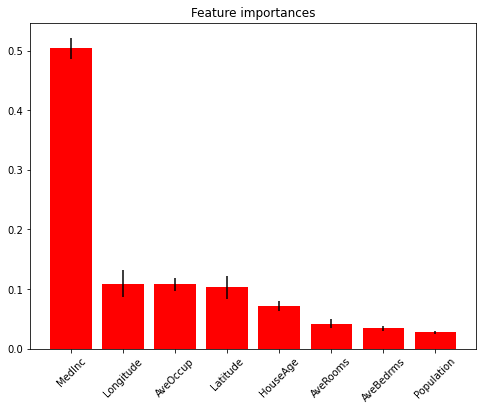

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(len(cal_housing.feature_names)), importances[indices],
        tick_label=[cal_housing.feature_names[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=45)

* An alternative approach is, instead of building models that are independent of each other, to build models sequentially.

* The idea now is that each model will predict what the previous models cannot predict.

* So with each model we progress overall to better predictions.

* This approach is called *boosting*.

* In scikit-learn we can use `AdaBoostRegressor` or `AdaBoostClassifier`.

In [10]:
from sklearn.ensemble import AdaBoostRegressor

clf = DecisionTreeRegressor()
ada_boost_rgr = AdaBoostRegressor(clf, n_estimators=50)
ada_boost_cv_scores = cross_val_score(ada_boost_rgr, 
                                      cal_housing.data,
                                      cal_housing.target,
                                      cv=KFold(n_splits=5, shuffle=True),
                                      scoring="neg_mean_absolute_error",
                                      n_jobs=-1)
print(-ada_boost_cv_scores.mean(), ada_boost_cv_scores.std())

0.3023612296511628 0.008245615049178277


* Similarly we can see the importance of each attribute.

In [11]:
clf = DecisionTreeRegressor()
ada_boost_rgr = AdaBoostRegressor(clf, n_estimators=50)
ada_boost_rgr.fit(cal_housing.data, cal_housing.target)
importances = ada_boost_rgr.feature_importances_

std = np.std([tree.feature_importances_ for tree in ada_boost_rgr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

for i in indices:
    print(cal_housing.feature_names[i], importances[i])

MedInc 0.30507539561303015
AveOccup 0.14658504911174752
Longitude 0.14503683390749428
Latitude 0.13993061209929938
HouseAge 0.07106249708545177
AveRooms 0.07048124965784512
Population 0.06437772631122357
AveBedrms 0.05745063621390814


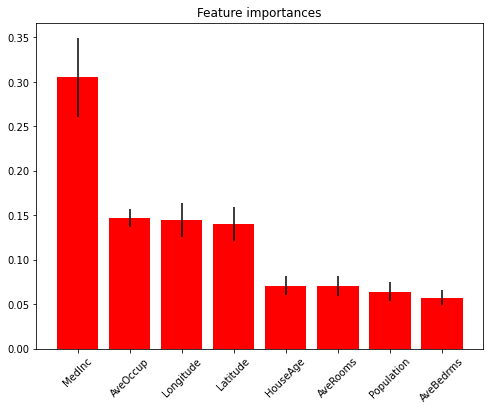

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
plt.bar(range(len(cal_housing.feature_names)), importances[indices],
        tick_label=[cal_housing.feature_names[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=45)

* A very good implementation of the boosting concept is [XGBoost](https://xgboost.readthedocs.io/en/latest/).

* The implementation is outside of scikit-learn, but we can use it in a completely similar way.

In [13]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()

scores = cross_val_score(xgb_reg, 
                         cal_housing.data, 
                         cal_housing.target, 
                         scoring="neg_mean_absolute_error", 
                         cv=KFold(n_splits=5, shuffle=True),
                         n_jobs=-1)

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from panda

* To see how we did:

In [14]:
print(-scores.mean(), scores.std())

0.31015113876669004 0.006924525305799936


* We can, as before, after training the model on our data, see the importance of the features.

In [15]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(cal_housing.data, cal_housing.target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

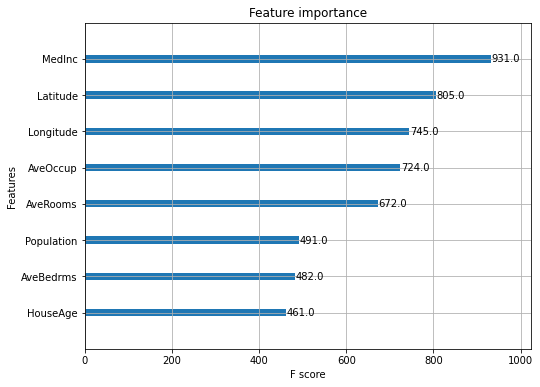

In [16]:
fig = plt.figure(figsize=(8, 6))
xgb_reg.get_booster().feature_names = cal_housing.feature_names
xgb.plot_importance(xgb_reg, ax = fig.gca())

* After leaving scikit-learn, another great implementation of the nudge idea is [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html).

In [17]:
import lightgbm as lgb

lgb_reg = lgb.LGBMRegressor()
scores = cross_val_score(lgb_reg, 
                         cal_housing.data, 
                         cal_housing.target,
                         scoring="neg_mean_absolute_error",
                         cv=KFold(n_splits=5, shuffle=True),
                         n_jobs=-1)

print(-scores.mean(), scores.std())

0.3105222418488509 0.006381049278185898


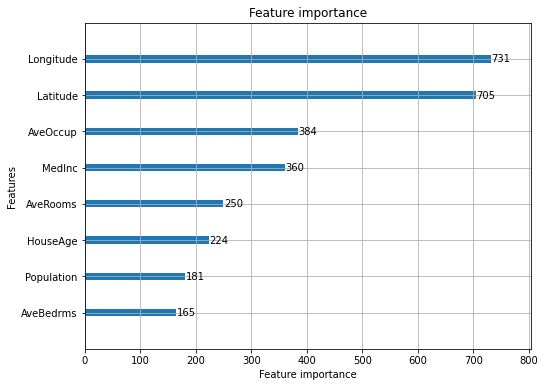

In [18]:
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(cal_housing.data, cal_housing.target, 
            feature_name=cal_housing.feature_names)
_ = lgb.plot_importance(lgb_reg, figsize=(8, 6))

* If we want to combine the results of different Machine Learning models, we can use them simultaneously and average the individual predictions.

* So by using a `VotingRegressor` (or `VotingClassifier`) we can combine LightGBM and XGBoost.

In [19]:
from sklearn.ensemble import VotingRegressor

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor()
vreg = VotingRegressor(estimators=[('xgb', xgb_reg), 
                                   ('lgb', lgb_reg)],
                       n_jobs=-1)
                       
scores = cross_val_score(vreg, 
                         cal_housing.data, 
                         cal_housing.target,
                         scoring='neg_mean_absolute_error', 
                         cv=KFold(n_splits=5, shuffle=True),
                         n_jobs=-1)

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 6a5c4df82b032e1ee1e5095e6f9baeb732b294db- is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 6a5c4df82b032e1ee1e5095e6f9baeb732b294db- is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.9/s

* To see how we did:

In [20]:
print(-scores.mean(), scores.std())

0.30153698375594207 0.00346104227856647


* Another way to combine models is to take the individual models and stack them under another model which uses their individual predictions to produce a combined prediction.

* We will use a `StackingRegressor`, which will combine the predictions of a LightGBM and an XGBoost via a linear regression model.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor()

estimators = [('xgb', xgb_reg), ('lgb', lgb_reg)]
final_estimator = LinearRegression()

sreg = StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

scores = cross_val_score(sreg, cal_housing.data, cal_housing.target,
                         cv=KFold(n_splits=5, shuffle=True), 
                         scoring='neg_mean_absolute_error', 
                         n_jobs=-1)

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pa

* To see how we did:

In [22]:
print(-scores.mean(), scores.std())

0.302862810944662 0.004650735610751247


* Combining models is usually the best way to improve the performance of a Machine Learning system.

* Although we saw examples of regression, the same applies (and is supported by the libraries) to classification.

* In any case, exploring alternative solutions to the problem in front of us will lead us to the optimal result!